Data ist from https://data.stadt-zuerich.ch/dataset/vbz-fahrzeiten-ogd . I used `head -n 1000000 fahrzeitensollist2017070220170708.csv > small.csv` to make a subset since I will do a lot of matrix multiplications which is slow.

We try different models to predict waiting time for a specific station (Goldbrunnenplatz) and line (tram 9) when time of day is given.

Since we are doing prediction rather than classical statistics, I decided to work with the package `scikit-learn` and not with `statsmodels`, even if `statsmodels` may be better for regressions.

In [23]:
%matplotlib inline
import numpy

from datetime import datetime, timedelta

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# Make plots reproducible
numpy.random.seed(0)

# Not necessary, but I like the ggplot style better
plt.style.use('ggplot') 

# Read csv to dataframe
df = pd.read_csv('small.csv')
df_hpunkt = pd.read_csv('haltepunkt.csv')
df_hstelle = pd.read_csv('haltestelle.csv')

Let's get the row of the station and line.

In [53]:
halt_id = df_hstelle[df_hstelle['halt_lang'] == 'Zürich, Goldbrunnenplatz']['halt_id'].item()
linie = 9
selection = df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie)]
print("Found %d records." % (len(selection)))
print(selection.head(3))

Found 1364 records.
       linie  richtung betriebsdatum  fahrzeug  kurs  seq_von  halt_diva_von  \
25910      9         2      02.07.17      3045     9        4           1012   
25924      9         1      02.07.17      2087     6       30           1012   
25978      9         1      02.07.17      3054     7       30           1012   

       halt_punkt_diva_von halt_kurz_von1 datum_von         ...          \
25910                    1           GOLP  02.07.17         ...           
25924                    0           GOLP  02.07.17         ...           
25978                    0           GOLP  02.07.17         ...           

       fahrweg_id  fw_no  fw_typ  fw_kurz      fw_lang  umlauf_von  \
25910       50260      2       1        2  HEUR - HIRZ      137963   
25924       50259      1       1        1  HIRZ - HEUR      135413   
25978       50259      1       1        1  HIRZ - HEUR      136401   

       halt_id_von halt_id_nach halt_punkt_id_von  halt_punkt_id_nach  
25910

Before we predict, let's explore the data a little bit.

...

## Multiple linear regression
1. Take continuous variables as independent variables.
2. Put them into a regression to predict delays. This gives a regression model.
3. Then drop the insignificant variables from the model and rerun it. Let's see what r^2 we get.

Coefficients: 
 [-0.00336107  0.        ]
Mean squared error: 2695.34
Variance score: -0.02


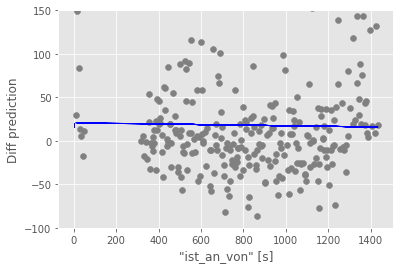

In [56]:
from sklearn import linear_model
from sklearn.svm import SVR

def makeDatetime(date, seconds):
    """Returns datetime object rounded to the hour.
    
    date: date in format dd.mm.yy
    seconds: seconds of the day (int, can be negative)
    """
    hour = int(seconds / 3600) # same as numpy.floor()
    minute = int((seconds - hour * 3600) / 60)

    dt_obj = datetime.strptime(date, '%d.%m.%y')
    if hour >= 24:
        dt_obj += timedelta(days=1)
        hour -= 24
    if hour < 0:
        dt_obj += timedelta(days=-1)
        hour += 24
    dt_obj = dt_obj.replace(hour=hour)
    
    if minute >= 60:
        dt_obj += timedelta(hours=1)
        minute -= 60
    if minute < 0:
        dt_obj += timedelta(hours=-1)
        minute += 60
    dt_obj = dt_obj.replace(minute=minute)

    return dt_obj


data_x = []
data_y = []
for index, row in selection.iterrows():
    dt_obj = makeDatetime(row['datum_von'], row['ist_an_von'])

    # It may cause a mproble that "richtung" has discrete values
    #d = [dt_obj.hour * 60 + dt_obj.minute, row['richtung']]
    d = [dt_obj.hour * 60 + dt_obj.minute, 0]
    data_x.append(d)
    
    diff = row['ist_an_von'] - row['soll_an_von']
    data_y.append(diff)

# Convert to numpy array
data_x = numpy.array(data_x)#.reshape(len(data_x), 1)
data_y = numpy.array(data_y)
    
# Split data into training and test set
length = len(data_x)
data_x_train = data_x[:-int(length*1/5)]
data_x_test = data_x[-(length-len(data_x_train)):]

data_y_train = data_y[:-int(length*1/5)]
data_y_test = data_y[-(length-len(data_y_train)):]

# Create the model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(data_x_train, data_y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % numpy.mean((regr.predict(data_x_test) - data_y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(data_x_test, data_y_test))

# Plot outputs
plt.scatter(data_x_test[:, 0], data_y_test, c='grey')
plt.plot(data_x_test, regr.predict(data_x_test), color='b', linewidth=1)
plt.gca().set_ylim([-100, 150])

plt.xlabel('"ist_an_von" [s]')
plt.ylabel('Diff prediction')
plt.show()

The model is not able to predict anything from the given data.

Let's plot the difference of times (delay) against time of day to explore the data.

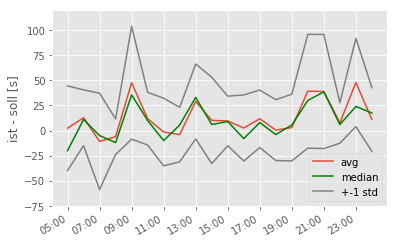

In [51]:
tod_diff = {}
# Take only the first rows because we only want about one day for a clear view
# The plot is reproducable for every successive selection
for index, row in selection[:200].iterrows():
    dt_obj = makeDatetime(row['datum_von'], row['ist_an_von']) # time from "soll"
    # Rounding to the hour to calculate mean, median etc. of the hour
    dt_obj = dt_obj.replace(minute=0)
    diff = row['ist_an_von'] - row['soll_an_von']
    
    if dt_obj not in tod_diff: 
        tod_diff[dt_obj] = []        
    tod_diff[dt_obj].append(diff)

# x
tod_times = []
# y
tod_avgs = [] 
tod_medians = []
tod_stdp = []
tod_stdn = []
for dt_obj in sorted(tod_diff):
    dt_diffs = tod_diff[dt_obj]

    mean = numpy.mean(dt_diffs)
    std = numpy.std(dt_diffs)
    
    tod_times.append(dt_obj)
    tod_avgs.append(mean)
    tod_medians.append(numpy.median(dt_diffs))
    tod_stdp.append(mean + std)
    tod_stdn.append(mean - std)

# Plot
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

ax.plot(tod_times, tod_avgs, label='avg')
ax.plot(tod_times, tod_medians, 'g', label='median')
ax.plot(tod_times, tod_stdp, 'grey', label='+-1 std')
ax.plot(tod_times, tod_stdn, 'grey', label='')
ax.legend()
ax.set_ylabel('ist - soll [s]')
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylim([-75, 120])

plt.show()

There seems to be some connection between time of day and delay. Why doesn't the linear regression reproduce that? The relationship between time and time difference is not linear. To forecast time series data with linear regression - like in this case - one would need a feature as input and then run through possible scenarios to forecast the effect on time difference/delay.

We could now try a Support Vector Machine, but they don't scale easily and take very long to compute.

---

Let's start with what I have been looking forward to:
$$P(H|D) = \frac{P(H) * P(D|H)}{P(D)}$$

## Bayes

I want to know: When I arrive at a certain station, how long do I have to wait for the next tram/bus/train?

We know the gap between arrival times of the transportation means (tram/bus/train) from the data. So we have the distribution of gap times given. Now

Passenger arrivals will be treated as a Poisson process (they are equally likely to arrive at any time). They arrive at an unknown rate λ [passengers per minute]. λ = λ(t) for t = time.



In [ ]:
# Copied from above for convenience
halt_id = df_hstelle[df_hstelle['halt_lang'] == 'Zürich, Goldbrunnenplatz']['halt_id'].item()
linie = 9
richtung = 1 # This is new
selection = df[(df['halt_id_von'] == halt_id) & (df['linie'] == linie) & (df['richtung'] == richtung)]

# Makes an datetime object from date string for correct sorting
#df['betriebsdatum'] = df['betriebsdatum'].apply(lambda x: datetime.strptime(x, '%d.%m.%y'))
# Consider: Sorting by betriebsdatum sorts by string, not by date. For correct sorting use the slow 'apply' method above
grouped = selection.sort_values(['betriebsdatum', 'ist_an_von']).groupby(['betriebsdatum'])
print("Found %d records." % (len(selection)))


gaps_over_time = {}
for date, group in grouped:
    ist_before = False
    for index, row in group.iterrows():
        if ist_before is False:
            ist_before = row['ist_an_von']
            continue
            
        gap = row['ist_an_von'] - ist_before
        secs = row['ist_an_von'] # Todo: correct values <0 and >= 86400 ?
        if secs not in gaps_over_time:
            gaps_over_time[secs] = []

        gaps_over_time[secs].append(gap)
        ist_before = row['ist_an_von']

times = []
gap_avgs = []
for time in sorted(gaps_over_time):
    times.append(time)
    gaps = gaps_over_time[time]
    gap_avgs.append(numpy.mean(gaps))
        
# Change to minutes for convenience
toMin = numpy.vectorize(lambda x: float(x)/60)
gaps_mins = toMin(gap_avgs)

plt.xlabel('time gap [min]')
plt.ylabel('CDF')
# Don't show outliers in hist
n, bins, patches = plt.hist(gaps_mins[gaps_mins < 20], bins=100, normed=1, histtype='step', cumulative=True, linewidth=1.5)
plt.show()

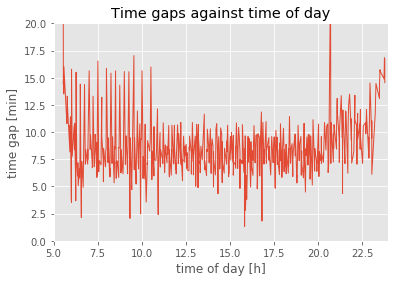

In [241]:
toHours = numpy.vectorize(lambda x: float(x)/3600)

plt.xlabel('time of day [h]')
plt.ylabel('time gap [min]')
plt.title('Time gaps against time of day')
plt.gca().set_ylim([0, 20]) # Because of outliers
plt.gca().set_xlim([5, 24])
plt.plot(toHours(times), gaps_mins, linewidth=1)
plt.show()